In [1]:
import warnings,sys
warnings.filterwarnings('ignore') 

In [2]:
import pandas as pd  
import numpy as np    
import matplotlib.pyplot as plt
import scipy
#from pygam import GAM, s, te

In [3]:
from sklearn import metrics
from sklearn.pipeline import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.linear_model import LinearRegression as OLS
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import *

In [4]:
from sklearn.model_selection import cross_validate

In [5]:
SAVE_GRAPHS = False 

In [6]:
######################################################################
######################################################################

In [7]:
def SciCor(x,y): 
    return scipy.stats.pearsonr(x,y)

def SimpleR2(x,y): 
    cor_val,p_value = SciCor(x,y) 
    if cor_val<=0: return 0.0
    return cor_val**2 

def SimpleR2_2(x,y): 
    r2 = r2_score(x,y) 
    if r2<0: return 0
    return r2 

def SimpleRmse(x,y):
    dif = np.array(x)-np.array(y)
    var = np.abs(dif)**2
    return (var.sum())/float(len(var))**0.5 


class PolyFit:
    def __init__(self,poly=[2,3,4,5]):
        if 'int' in str(type(poly)): poly=[poly]
        self.poly = poly
        self.models = {}
        
    def fit(self,x_train,y_train,poly=[]):
        if poly: 
            if 'int' in str(type(poly)): poly=[poly]
            self.poly = poly
        x = np.array(x_train)
        y = np.array(y_train)
        if x.shape == (len(x),1): x = x.reshape([len(x),]) 
        if y.shape == (len(y),1): x = x.reshape([len(y),])  
        results = []
        for deg in self.poly:
            params = np.polyfit(x,y,deg)
            self.models[deg] = params    
    def predict(self,x_test): 
        x = np.array(x_test) 
        if x.shape == (len(x),1): x = x.reshape([len(x),])
        results = []
        for deg in self.poly:
            params = self.models[deg] 
            preds = np.polyval(params,x)
            results.append(preds)
        M = np.array(results)
        preds_final = M.mean(0) 
        return preds_final 
    

In [8]:
######################################################################
######################################################################

In [9]:
fn = 'DATA/XDFR2.csv'
XDF = pd.read_csv(fn) 

fn = 'DATA/YDFR2.csv'
YDF = pd.read_csv(fn)

In [10]:
# ~~~ Optional ~~~
# Isolating only the feature columns having _PCT as a suffix...
xcols = [a for a in XDF.columns if "_PCT" in a]
XDF = XDF[xcols].copy() 

In [11]:
XDF.head()

,POP_00_PCT,POP_05_PCT,POP_10_PCT,POP_15_PCT,POP_20_PCT,POP_25_PCT,POP_30_PCT,POP_35_PCT,POP_40_PCT,POP_45_PCT,...,HU_VEHICLES_2_PCT,HU_VEHICLES_3_PCT,HU_GAS_PCT,HU_BOTTLE_PCT,HU_ELECTRIC_PCT,HU_COAL_PCT,HU_WOOD_PCT,HU_SOLAR_PCT,HU_OTHER_FUEL_PCT,HU_NO_FUEL_PCT
0,6.182177,6.478132,6.905623,7.596185,4.768168,4.570865,5.195659,6.741204,7.859257,7.826373,...,43.989071,21.857923,2.094718,43.260474,45.264117,0.000000,0.819672,0.000000,0.000000,0.000000
1,4.241827,4.401896,4.525026,4.808225,3.995567,4.217201,4.094071,4.094071,5.134519,6.482793,...,37.544387,21.797323,14.354002,2.594919,74.364928,0.000000,0.901393,0.327779,0.068287,0.000000
2,5.755396,6.504796,7.224221,7.643885,4.286571,5.005995,4.886091,6.414868,7.254197,7.404077,...,35.635793,27.237049,42.935636,16.954474,17.974882,0.235479,10.989011,0.000000,0.392465,0.235479
3,6.909427,6.470045,6.309755,6.600162,8.412378,9.102567,7.988082,7.011258,6.590733,6.811367,...,30.420160,10.743214,3.353702,0.525792,93.865757,0.000000,0.000000,0.000000,0.028421,0.876320
4,9.408909,8.850045,8.374806,8.697071,7.157135,7.632373,7.997471,8.158603,6.938892,6.728808,...,37.019435,13.399064,0.333381,0.993049,94.864520,0.000000,0.000000,0.085118,0.000000,2.447156


In [12]:
YDF.head() 

,CleanZip,POP_TOT,A,B,C,D,E,F,G,H,...,J,K,L,M,N,O,P,Q,R,S
0,15239,3041,6.0,0.0,0.0,8.0,0.0,6.0,0.0,0.0,...,79.0,3.0,15.0,0.0,0.0,31.0,0.0,52.0,8.0,0.0
1,15247,16243,3.0,5.0,3.0,4.0,0.0,28.0,0.0,31.0,...,677.0,4.0,73.0,0.0,0.0,133.0,0.0,178.0,13.0,0.0
2,15256,3635,0.0,0.0,0.0,6.0,0.0,7.0,0.0,7.0,...,65.0,0.0,10.0,0.0,0.0,0.0,0.0,18.0,7.0,0.0
3,15264,53029,11.0,6.0,8.0,2.0,0.0,53.0,0.0,91.0,...,573.0,28.0,87.0,0.0,2.0,510.0,3.0,318.0,47.0,0.0
4,15272,49028,33.0,13.0,6.0,4.0,0.0,66.0,0.0,55.0,...,856.0,36.0,149.0,0.0,0.0,206.0,0.0,358.0,79.0,2.0


In [13]:
YVar = 'K'
cols = ['CleanZip','POP_TOT',YVar]
YDF = YDF[cols]
YDF.columns = [a.replace(YVar,'Sales') for a in YDF.columns]
YDF['Scaled'] = 10000.0*YDF['Sales']/YDF['POP_TOT'] 

In [14]:
YDF.head()

,CleanZip,POP_TOT,Sales,Scaled
0,15239,3041,3.0,9.865176
1,15247,16243,4.0,2.462599
2,15256,3635,0.0,0.000000
3,15264,53029,28.0,5.280130
4,15272,49028,36.0,7.342743


In [15]:
yvar,xvar = "Scaled","POP_00_PCT" 
y = YDF[yvar].values
x = XDF[xvar].values 

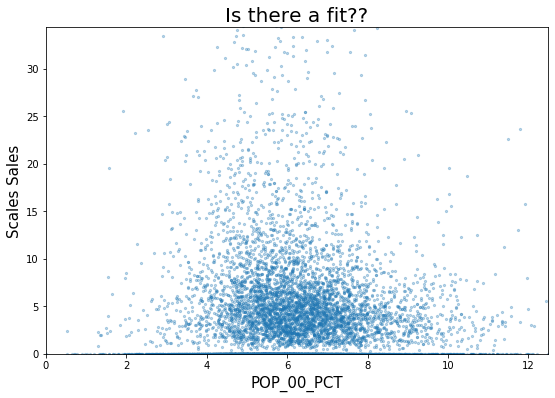

In [16]:
plt.figure(figsize=(9,6))
plt.scatter(x,y, s=5, alpha=.3) 
ymax = np.percentile(y,99)
xmax = np.percentile(x,99.5) 
plt.ylim([0,ymax])
plt.xlim([0,xmax]) 
plt.title('Is there a fit??',size=20)
plt.xlabel(xvar,size=15)
plt.ylabel('Scales Sales',size=15)
plt.show() 

In [17]:
model = PolyFit(4)
model.fit(x,y); 
x_test = np.linspace(x.min(),x.max(),1000) 
y_test = model.predict(x_test)  

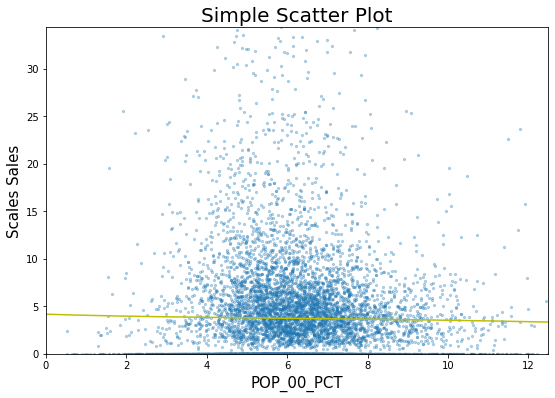

In [18]:
plt.figure(figsize=(9,6))
plt.scatter(x,y, s=5, alpha=.3)
plt.plot(x_test,y_test,c='y')
ymax = np.percentile(y,99)
xmax = np.percentile(x,99.5) 
plt.ylim([0,ymax])
plt.xlim([0,xmax])
plt.title('Simple Scatter Plot',size=20)
plt.xlabel(xvar,size=15)
plt.ylabel('Scales Sales',size=15)
plt.show() 

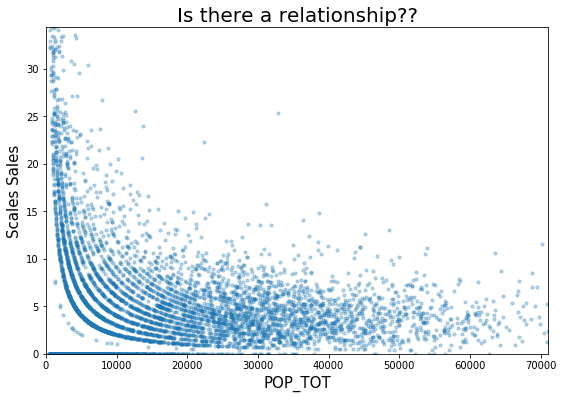

In [19]:
yvar,xvar = "Scaled","POP_TOT" 
y = YDF[yvar].values
x = YDF[xvar].values 

plt.figure(figsize=(9,6))
plt.scatter(x,y, s=10, alpha=.3) 
ymax = np.percentile(y,99)
xmax = np.percentile(x,99.5) 
plt.ylim([0,ymax])
plt.xlim([0,xmax]) 
plt.title('Is there a relationship??',size=20)
plt.xlabel(xvar,size=15)
plt.ylabel('Scales Sales',size=15)
plt.show() 

In [20]:
######################################################################
######################################################################

In [21]:
# Function for Converting Sales to Demand-Index (DI):   
def sales2di(n_sales,n_pop):
    if np.shape(n_sales)==(): n_sales = max(n_sales,0)
    else: n_sales = np.clip(n_sales,0,np.inf) 
    demand_index = np.log((n_sales+1.0)/(n_pop+500.0))+10.0
    return demand_index 

# Function for Converting Demand-Index (DI) to Sales: 
def di2sales(dindex,n_pop):
    sales = (np.exp(dindex-10.0)*(n_pop+500.0))-1.0 
    if np.shape(sales)==(): return round(max(0.0,sales),9) 
    return np.around(np.clip(sales,0.0,np.inf),9) 

In [22]:
# Testing reflective conversion between Sales <> DI for a SINGLE instance:
n_sales, n_pop = 17, 5432
print(n_sales)
di = sales2di(n_sales,n_pop) 
print(di)
n_sales2 = di2sales(di,n_pop) 
print(n_sales2) 

17
4.202255054638342
17.0


In [23]:
# Testing reflective conversion between Sales <> DI for a BATCH instance:
n_sales,n_pop = np.array([17,-5,0,1,543]),np.array([5432,100,50,300,10234]) 
print(n_sales)
di = sales2di(n_sales,n_pop) 
print(di)
n_sales2 = di2sales(di,n_pop) 
print(n_sales2)

[ 17  -5   0   1 543]
[4.20225505 3.60307034 3.69008172 4.00853545 7.01777769]
[ 17.   0.   0.   1. 543.]


In [24]:
YDF['DI'] = sales2di(YDF['Sales'],YDF['POP_TOT']) 

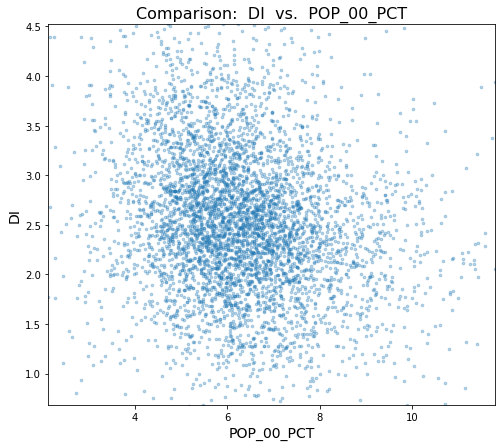

In [25]:
# Filtering to ONLY instances having >0 sales over timeframe:
TF = YDF['Sales'] > 0.1 
YDF2 = YDF[TF].copy()
XDF2 = XDF[TF].copy() 

# Comparing Category Demand Index to a specific factor variable: 
yvar,xvar = "DI","POP_00_PCT" 
y = YDF2[yvar].values
x = XDF2[xvar].values  

plt.figure(figsize=(8,7))
plt.scatter(x,y, s=7, alpha=.3) 

ymin,ymax = np.percentile(y,0.5),np.percentile(y,99.5)
xmin,xmax = np.percentile(x,0.5),np.percentile(x,99.5)

plt.title('Comparison:  '+yvar+'  vs.  '+xvar,size=16)
plt.xlabel(xvar,size=14)
plt.ylabel(yvar,size=14)
plt.ylim([ymin,ymax])
plt.xlim([xmin,xmax])

name = yvar+' vs '+xvar+'.png'
fn = 'GRAPHS/SIMPLE/'+name
plt.savefig(fn,dpi=200)
plt.show() 

In [26]:
Observations = '''

After the observed sales have been propperly scaled as a demand index, 
we can observe that there is no linear OR non-linear relationship between 
DI and POP_00_PCT. Therefore, to model the outcome variable, we must
exhaustively test all prospect factor variables to identify which variables
actualy exhibit some statistical relationship with DI.

Once we identify this top set of variables, we will use only that set in 
our subsequent modeling pipeline.

'''

In [27]:
######################################################################
###################################################################### 

In [28]:
# Here we are going to test every single factor variable to see
# whether a simple 2nd degree polynomial model can render predictions 
# on the outcome variable that are statistically significant.

xcols = list(XDF.columns) 

Results = [] 

TF = YDF['Sales'] > 0.1
YDF2 = YDF[TF].copy()
XDF2 = XDF[TF].copy()  

for xcol in xcols:   
    
    yvar,xvar = "DI",xcol  
    y = YDF2[yvar].values
    x = XDF2[xvar].values  

    if SAVE_GRAPHS:
        plt.figure(figsize=(8,7))
        plt.scatter(x,y, s=5, alpha=.2) 

    ymin,ymax = np.percentile(y,1),np.percentile(y,99)
    xmin,xmax = np.percentile(x,1),np.percentile(x,99) 
    
    tf1 = (x >= xmin) & (x <= xmax)   
    tf2 = (y >= ymin) & (y <= ymax) 
    tf3 = (tf2&tf2) 
    x2,y2 = x[tf3],y[tf3] 
    
    try:
        # Creating and fitting the 2nd degree polynomial model:
        model = PolyFit(2)
        model.fit(x2,y2)
        x_pred = np.linspace(x.min(),x.max(),1000) 
        y_pred = model.predict(x_pred)
        if SAVE_GRAPHS:
            plt.plot(x_pred,y_pred,c='y')
    except: 
        pass
    
    try: cor,p = SciCor(x2,y2) 
    except: break 
    
    Results.append([yvar,xvar,cor,cor**2,p])  
    
    if not SAVE_GRAPHS: continue 
    
    plt.title('Comparison:  '+yvar+'  vs.  '+xvar+'  '+str(round(cor,3)),size=16) 
    plt.xlabel(xvar,size=14)
    plt.ylabel(yvar,size=14)
    
    try:
        plt.ylim([ymin,ymax])
        plt.xlim([xmin,xmax])
    except:
        plt.clf() 
        continue

    name = yvar+' vs '+xvar+'.png'
    fn = 'GRAPHS/SIMPLE2/'+name 
    plt.savefig(fn,dpi=200)
    plt.clf();    


/Users/james.rolfsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RankWarning: Polyfit may be poorly conditioned


In [29]:
Cols = ['YVAR','XVAR','COR','R2','PVAL']
RDF = pd.DataFrame(Results)
RDF.columns = Cols
RDF['PVAL'] = np.around(RDF['PVAL'],6) 
RDF = RDF.sort_values(['R2'],ascending=False) 

In [30]:
RDF.head(10)  

,YVAR,XVAR,COR,R2,PVAL
62,DI,HH_SPOUSE_PCT,0.378299,0.143110,0.0
93,DI,HU_OCC_RENT_PCT,-0.355451,0.126345,0.0
103,DI,NOW_MARRIED_F_PCT,0.352175,0.124027,0.0
102,DI,NEVER_MARRIED_F_PCT,-0.346813,0.120279,0.0
96,DI,NEVER_MARRIED_M_PCT,-0.332656,0.110660,0.0
34,DI,NH_WHITE_PCT,0.331590,0.109952,0.0
92,DI,POP_OWNERS_PCT,0.331490,0.109885,0.0
94,DI,POP_RENTERS_PCT,-0.323773,0.104829,0.0
76,DI,HH_FEM_WCH_PCT,-0.322095,0.103745,0.0
75,DI,HH_FEM_PCT,-0.320433,0.102677,0.0


In [31]:
# Isolating the top 25 most significant factor variables: 
XVarsTop25 = RDF['XVAR'].values[:25] 
X25 = XDF2[XVarsTop25].copy() 

In [32]:
# Constructing different modeling pipelines: 
estimators = [
    ('scaler',StandardScaler()),  #<<<<< GOOD!
    #('reduce_dim', PCA(10)), 
    #('clf', OLS())
    #('clf', GBR())
    #('clf', GAM()) 
    ('clf', MLP([50]))           #<<<<< GOOD! 
] 
pipe_model = Pipeline(estimators) 

In [33]:
# Fitting the pipeline model on all available data:
y = YDF2[yvar].values
X = X25.values 
pipe_model.fit(X,y);
preds = pipe_model.predict(X) 

In [34]:
# Executing a 12-fold cross validation test of performance via R-Squared score:
rs = ShuffleSplit(n_splits=12) 
cv_results = cross_validate(pipe_model,X,y,cv=rs,n_jobs=3,scoring='r2')  
print(cv_results['test_score'])
print(cv_results['test_score'].mean()) 

[0.41932484 0.31976342 0.3189599  0.36462788 0.36752087 0.41915712
 0.4530276  0.3735495  0.40667216 0.32829614 0.37231514 0.40163301]
0.37873729684825497


In [35]:
Notes = '''

PERFORMANCE TESTS:
0.00000  GAM() w/PCA  #<< WORST
0.18193  OLS() w/PCA 
0.20017  OLS() 
0.27811  GBR() w/PCA 
0.35087  MLP([50,50])
0.36224  GBR() 
0.37699  MLP([30,30]) 
0.38132  MLP([30])
0.39041  MLP([50])   #<< BEST
'''

In [36]:
try:
    explained = pipe_model.steps[1][1].explained_variance_ratio_
    explained_c = np.cumsum(explained) 
    print(explained_c)
except: pass

R2: 0.5151


<Figure size 432x288 with 0 Axes>

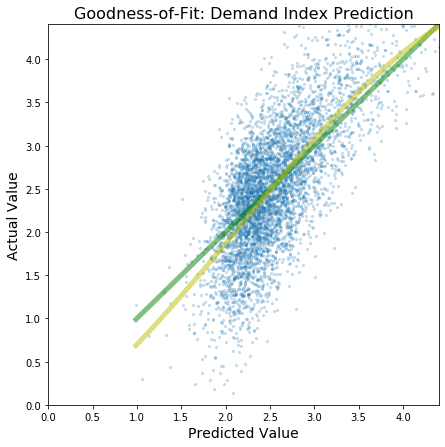

In [37]:
# Plotting model predictions for DI versus actual values for DI: 
y = YDF2[yvar].values
x = preds 

plt.clf()
plt.figure(figsize=(7,7))
plt.scatter(x,y, s=5, alpha=.2);

ymin,ymax = np.percentile(y,1),np.percentile(y,99)
xmin,xmax = np.percentile(x,1),np.percentile(x,99) 

tf1 = (x >= xmin) & (x <= xmax)   
tf2 = (y >= ymin) & (y <= ymax) 
tf3 = (tf2&tf2) 
x2,y2 = x,y #x[tf3],y[tf3]

cor,p = SciCor(x2,y2) 
r2 = cor**2
print('R2:',round(r2,5))

x_pred = np.linspace(x.min(),x.max(),1000) 
plt.plot(x_pred,x_pred,c='g',lw=5,alpha=0.5) 

try:
    model = PolyFit(3)
    model.fit(x2,y2)    
    y_pred = model.predict(x_pred)
    plt.plot(x_pred,y_pred,c='y',lw=5,alpha=0.5) 
except: 
    pass

plt.title('Goodness-of-Fit: Demand Index Prediction',size=16) 
plt.xlabel('Predicted Value',size=14)
plt.ylabel('Actual Value',size=14)

maxim = max(ymax,xmax)
plt.ylim([0,maxim])
plt.xlim([0,maxim])
plt.show();

In [38]:
# Recalculating results as PREDICTED SALES rather than DI values:
#sales_var = yvar.replace('DI','SALES')
sales = YDF2['Sales'] 
sales_pred = di2sales(preds,YDF2['POP_TOT']) 

R2: 0.56168


<Figure size 432x288 with 0 Axes>

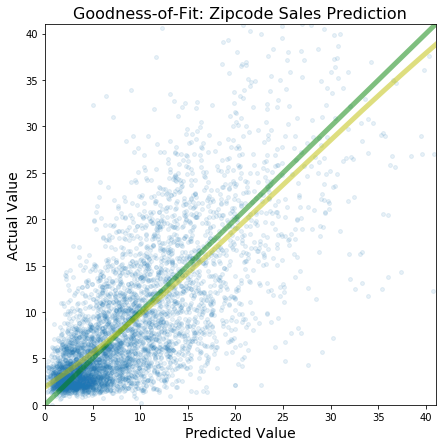

In [39]:
y = sales
x = sales_pred 

plt.clf()
plt.figure(figsize=(7,7))

ymin,ymax = np.percentile(y,1),np.percentile(y,99)
xmin,xmax = np.percentile(x,1),np.percentile(x,99) 

tf1 = (x >= xmin) & (x <= xmax)   
tf2 = (y >= ymin) & (y <= ymax) 
tf3 = (tf2&tf2) 
x2,y2 = x,y 

cor,p = SciCor(x2,y2) 
r2 = cor**2
print('R2:',round(r2,5))

x2 = x2 + np.random.normal(0,0.4,len(x2))
y2 = y2 + np.random.normal(0,0.4,len(y2))

plt.scatter(x2,y2, s=15, alpha=.1);
x_pred = np.linspace(x.min(),x.max(),1000) 
plt.plot(x_pred,x_pred,c='g',lw=5,alpha=0.5) 

try:
    model = PolyFit(3)
    model.fit(x2,y2)    
    y_pred = model.predict(x_pred)
    plt.plot(x_pred,y_pred,c='y',lw=5,alpha=0.5) 
except: 
    pass

plt.title('Goodness-of-Fit: Zipcode Sales Prediction',size=16) 
plt.xlabel('Predicted Value',size=14)
plt.ylabel('Actual Value',size=14)

maxim = max(ymax,xmax)

plt.ylim([0,maxim])
plt.xlim([0,maxim])
fn = 'DATA/SALES MODEL.png'
plt.savefig(fn,dpi=200);
plt.show(); 
#plt.clf()
z=1 

In [40]:
######################################################################
######################################################################

In [41]:
# END

In [42]:
x=0